In [1]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

def obtain_fda_results(api_key, drug_term):
    base_url = "https://api.fda.gov/drug/event.json"
    
    # Search parameters
    params = {
        'api_key': api_key,
        'search': f'"patient.drug.medicinalproduct.exact:""{drug_term}"',
        'count': "patient.reaction.reactionmeddrapt.exact"
        }

    headers = {
        'Content-Type': 'application/json',
    }

    try:
        # Api call
        response = requests.get(base_url,  params=params, headers=headers)
        response.raise_for_status()  # Check if there are errors in the HTTP response

        # Convert the response to JSON
        data = response.json()

        # Check if 'results' is present
        if 'results' in data:
            # Return the resulting json
            return data
        else:
            print(f"There are no results for {drug_term}")
            return None
    
    except requests.exceptions.RequestException as e:
        print(f"Error in the api call for {drug_term}: {e}")

def obtain_fda_results_from_list(api_key, drugs):
    
    df_results = pd.DataFrame(columns=['drug', 'term', 'count'])

    for drug in drugs['drug']:
        data = obtain_fda_results(api_key,drug)
        
        # Check if 'results' is present in data
        if data is not None and 'results' in data:
            # Create a DataFrame for the current drug's results
            df_drug = pd.DataFrame(data['results'])
            df_drug['drug'] = drug
            
            # Concatenate to the main DataFrame
            df_results = pd.concat([df_results, df_drug], ignore_index=True)
        
        # Add a 1 second delay
        time.sleep(1)

    return df_results

In [2]:
#Function for data  preprocessing

def data_preprocessing(results_df, rows = "drug", columns = "term", cellValues = "count", num_top_events = 12):
    #Preprocessing of the dataframe

    # We use the pivot_table function (handles duplicates) to convert the long DataFrame to a wide one
    results_df_wide = results_df.pivot_table(index=rows, columns=columns, values=cellValues)

    # We remove the drug label as a column name
    results_df_wide.columns.name = None

    # We reset the indices so that the tumor type and the drug names are at the same level
    results_df_wide.reset_index(inplace=True)

    # We extract the 12 events with the highest number of results in the bibliography. Independently of the tumor type
    top_events = results_df_wide.drop(columns=[rows]).sum().sort_values(ascending=False).head(num_top_events)

    # We filter the dataframe to keep only the tumor type column and the drugs with the most results
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]

    # We define the tumor type as the indices of the dataframe
    results_df_wide.set_index(rows, inplace=True)

    # We sum the total number of results of the 15 drugs for each tumor type and create a new column called 'TotalResults'
    results_df_wide['TotalResults'] = results_df_wide[list(top_events.index)].sum(axis=1)

    # We sort the dataframe by the new column 'TotalResults' in descending order
    results_df_wide = results_df_wide.sort_values(by='TotalResults', ascending=False).reset_index()
    results_df_wide = results_df_wide[[rows] + list(top_events.index)]
    results_df_wide.set_index(rows, inplace=True)

    results_df = results_df_wide.fillna(0)
    
    return results_df, top_events

def bar_plot_results(results_df_wide, top_events, num_columns = 25, xlab = 'Drugs', 
                     plot_title ='Drugs and adverse effects. Source:Faers', legend_title = 'Adverse effects'):
    # Visualize the results of each drug in function of the tumor type

    # Configure the unique color palette for each drug with Seaborn
    colors = sns.color_palette("Set3", n_colors=len(top_events))

    # We create a stacked bar plot
    ax = results_df_wide.head(num_columns).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

    # We add labels and title
    ax.set_xlabel(xlab, fontsize=12)
    ax.set_ylabel('Number of Results', fontsize=12)
    ax.set_title(plot_title, fontsize=14)
    ax.legend(title= legend_title, bbox_to_anchor=(1.05, 1), loc='upper left')  # Place the legend to the right
    plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels
    plt.tight_layout()  # Adjust the layout of the plot
    plt.show()

In [3]:
# Reemplaza 'tu_token_aqui' con tu token real
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drug_term = 'ipilimumab'

response= obtain_fda_results(token_api, drug_term)


In [5]:
with open('../results/output.json', 'w', encoding='utf-8') as f:
            json.dump(response, f, ensure_ascii=False, indent=2)

In [6]:
token_api = 'pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH'
drugs = pd.read_csv("../data/drugs.csv", header = None, names = ['drug'])

In [9]:
results = obtain_fda_results_from_list(token_api, drugs)
results

Error in the api call for emtansine trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22emtansine+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact
Error in the api call for deruxtecan trastuzumab: 404 Client Error: Not Found for url: https://api.fda.gov/drug/event.json?api_key=pqnh6L01FAfMHzGvbu6PoEXoHoqQLIXFgxWCAaoH&search=%22patient.drug.medicinalproduct.exact%3A%22%22deruxtecan+trastuzumab%22&count=patient.reaction.reactionmeddrapt.exact


,drug,term,count
0,pembrolizumab,MALIGNANT NEOPLASM PROGRESSION,9435
1,pembrolizumab,DEATH,4728
2,pembrolizumab,DIARRHOEA,4370
3,pembrolizumab,FATIGUE,4111
4,pembrolizumab,OFF LABEL USE,3777
...,...,...,...
6195,sotorasib,ILLNESS,10
6196,sotorasib,PRODUCT DOSE OMISSION ISSUE,10
6197,sotorasib,RADIOTHERAPY,10
6198,sotorasib,THERAPY INTERRUPTED,10


In [11]:
# Save the search results in faers in .csv
results.to_csv('../results/faers_results.csv', index=False)

In [12]:
# Load data from Faers 
results_df = pd.read_csv('../results/faers_results.csv')
results_df = results_df.fillna(0)

In [13]:
results_df

,drug,term,count
0,pembrolizumab,MALIGNANT NEOPLASM PROGRESSION,9435
1,pembrolizumab,DEATH,4728
2,pembrolizumab,DIARRHOEA,4370
3,pembrolizumab,FATIGUE,4111
4,pembrolizumab,OFF LABEL USE,3777
...,...,...,...
6195,sotorasib,ILLNESS,10
6196,sotorasib,PRODUCT DOSE OMISSION ISSUE,10
6197,sotorasib,RADIOTHERAPY,10
6198,sotorasib,THERAPY INTERRUPTED,10


In [44]:
adverse_effects = pd.read_csv("../data/adverse_effects.csv")
retain_columns = list(adverse_effects[adverse_effects.columns[0]])
retain_columns

['dysphagia', 'nausea']

In [45]:
filter_results_df = results_df[results_df['term'].str.lower().isin([adverse_effect.lower() for adverse_effect in retain_columns])]
filter_results_df

,drug,term,count
7,pembrolizumab,NAUSEA,2824
79,pembrolizumab,DYSPHAGIA,536
111,osimertinib,NAUSEA,573
162,osimertinib,DYSPHAGIA,145
207,nivolumab,NAUSEA,2819
...,...,...,...
5904,temozolomide,NAUSEA,1573
5969,temozolomide,DYSPHAGIA,187
6001,oxaliplatin,NAUSEA,5655
6068,oxaliplatin,DYSPHAGIA,679


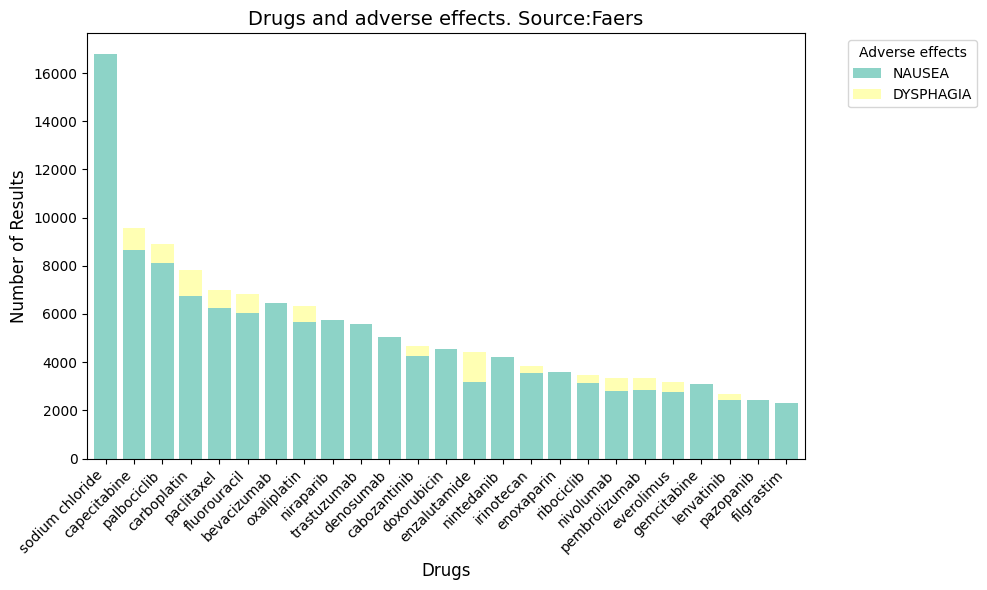

In [46]:
filter_results_df_wide, top_drugs = data_preprocessing(filter_results_df)

# Visualize the results of each adverse effect in function of the drug
bar_plot_results(filter_results_df_wide, top_drugs)

In [47]:
results_df_wide, top_drugs = data_preprocessing(results_df)
results_df_wide

,DEATH,DIARRHOEA,OFF LABEL USE,FATIGUE,NAUSEA,VOMITING,MALIGNANT NEOPLASM PROGRESSION,PYREXIA,DYSPNOEA,DRUG INEFFECTIVE,ASTHENIA,DISEASE PROGRESSION
drug,,,,,,,,,,,,
sodium chloride,23695.0,14031.0,18794.0,15848.0,16809.0,14286.0,0.0,13312.0,16196.0,21343.0,10233.0,0.0
denosumab,19314.0,4860.0,36065.0,6999.0,5040.0,2466.0,2024.0,2247.0,3409.0,2910.0,3778.0,1265.0
bevacizumab,12568.0,7066.0,12211.0,6054.0,6450.0,4912.0,2492.0,3929.0,3406.0,2930.0,3473.0,7009.0
capecitabine,9017.0,13963.0,3624.0,6677.0,8641.0,6314.0,3626.0,2476.0,2687.0,2455.0,3393.0,6010.0
carboplatin,4135.0,5790.0,7265.0,4391.0,6759.0,5045.0,5411.0,4516.0,5459.0,3699.0,3480.0,5516.0
...,...,...,...,...,...,...,...,...,...,...,...,...
trabectedin,64.0,80.0,111.0,93.0,185.0,144.0,50.0,102.0,64.0,88.0,105.0,117.0
plerixafor,54.0,104.0,121.0,40.0,88.0,55.0,11.0,93.0,51.0,52.0,24.0,20.0
selpercatinib,84.0,48.0,26.0,49.0,23.0,15.0,92.0,36.0,10.0,34.0,22.0,16.0


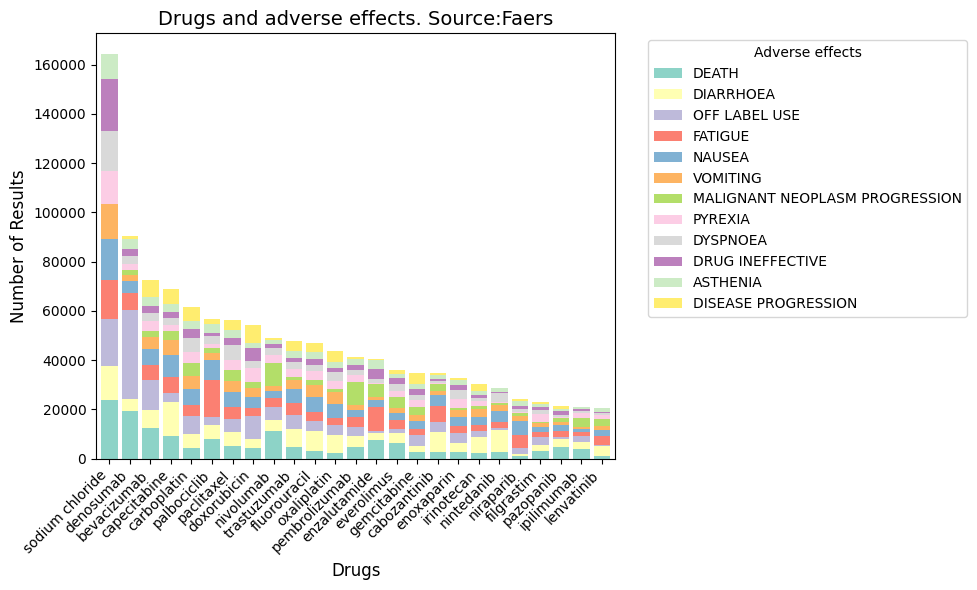

In [48]:
# Visualize the results of each adverse effect in function of the drug
bar_plot_results(results_df_wide, top_drugs)